<a href="https://colab.research.google.com/gist/kl543/93cc43a67b0510e132a35c1d7baffad7/homework_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 02: Visualization and Expectation-Maximization

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess

Helpers for Getting, Loading and Locating Data

In [27]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

In [28]:
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/pong_data.hf5')
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/pong_targets.hf5')

File ‘./tmp_data/pong_data.hf5’ already there; not retrieving.
File ‘./tmp_data/pong_targets.hf5’ already there; not retrieving.


In [29]:
pong_data    = pd.read_hdf(locate_data('pong_data.hf5'))
pong_targets = pd.read_hdf(locate_data('pong_targets.hf5'))

## <span style="color:Orange">Problem 1</span>

We often coerce data for machine learning into a 2D array of samples x features, but this sometimes obscures the natural structure of the data.  In these cases, it is helpful to use special-purpose visualizations that know about this natural structure.

Samples of `pong_data` encode 2D trajectories of a ping-pong ball. Implement the function below to transform one sample into a 2D array of trajectory coordinates suitable for plotting:

In [30]:
def sample_to_trajectory(sample):
    """Reshape a pong data sample of length N into an (x,y) array of shape (2, N/2).

    Parameters
    ----------
    sample : array
        Numpy array of length N.

    Returns
    -------
    array
        Array of length (2, N/2) where the first index is 0, 1 for x, y coordinates.
    """
    assert len(sample) % 2 == 0, 'len(sample) is not divisible by two.'
    # YOUR CODE HERE
    s = np.asarray(sample)
    N = s.size

    return s.reshape(2, N // 2)

    #raise NotImplementedError()

In [31]:
# A correct solution should pass these tests.
sample = np.arange(10)
xy = sample_to_trajectory(sample)
assert xy.shape == (2, 5)
assert np.array_equal(xy[0], [0, 1, 2, 3, 4])
assert np.array_equal(xy[1], [5, 6, 7, 8, 9])

Use the function below to plot some samples as trajectories, color coded by their target "grp" value:

In [32]:
def plot_trajectories(nrows=50):
    for row in range(nrows):
        x, y = sample_to_trajectory(pong_data.iloc[row].values)
        grp = int(pong_targets['grp'][row])
        color = 'krb'[grp]
        plt.plot(x, y, ls='-', c=color)

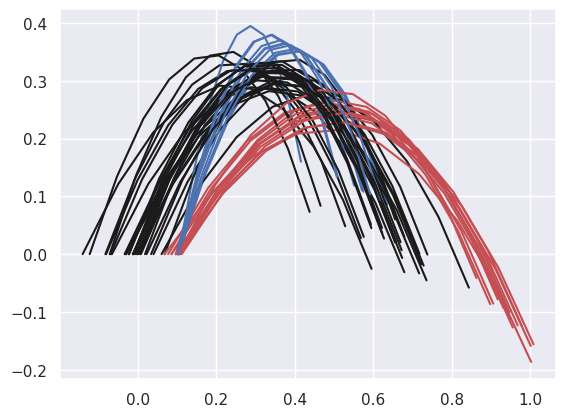

In [33]:
plot_trajectories()

It should be obvious from this plot why the `y0` column is all zeros.

Implement the function below using `sns.distplot` to show the distribution of `x0` values for each value (0, 1, 2) of the target `grp`.  Your plot should resemble this one:

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/Homework02-compare_groups.png" width=600></img>
</div>

/tmp/ipython-input-323967711.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df["grp"] == g, "x0"])
/tmp/ipython-input-323967711.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df["grp"] == g, "x0"])
/tmp/ipython-input-323967711.py:10: UserWarning: 

`distplot` is a depre

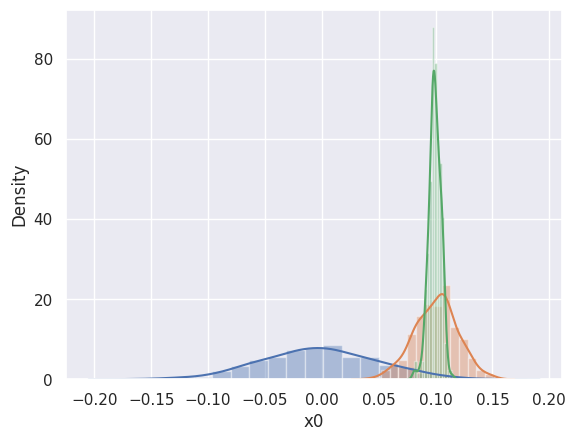

In [36]:
def compare_groups():
    """Plot 1D distributions of the x0 feature for each group (grp=0,1,2).
    """
    # YOUR CODE HERE
    df = pong_data.copy()
    df["grp"] = pong_targets["grp"].astype(int)

    # ploting
    for g in (0, 1, 2):
        sns.distplot(df.loc[df["grp"] == g, "x0"])

    plt.xlabel("x0")
    plt.ylabel("Density")
    #raise NotImplementedError()

compare_groups()

To get some insight into the `th0` target, implement the function below to add a `slope` column to `pong_data` that calculates the initial trajectory slope, then make a scatter plot of `slope` versus `th0` using `sns.jointplot`.  Your plot should resemble this one:

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/Homework02-compare_slope_th0.png" width=600></img>
</div>

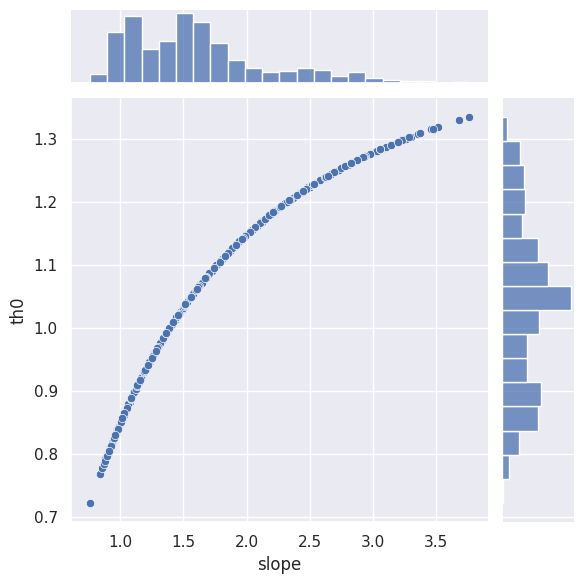

In [37]:
def compare_slope_th0():
    """Display scatter plot of calculated initial slope vs target th0.
    """
    # YOUR CODE HERE

    df = pong_data.copy()
    dx = df['x1'] - df['x0']
    dy = df['y1'] - df['y0']
    df["slope"] = dy / dx
    df["th0"] = pong_targets["th0"]

    sns.jointplot(df, x="slope", y="th0")
    #raise NotImplementedError()

compare_slope_th0()

## <span style="color:Orange">Problem 2</span>

The normal (aka Gaussian) distribution is one of the fundamental probability densities that we will encounter often.

Implement the function below using `np.random.multivariate_normal` to generate random samples from an arbitrary multidimensional normal distribution, for a specified random seed:

In [38]:
def generate_normal(mu, C, n, seed=123):
    """Generate random samples from a normal distribution.

    Parameters
    ----------
    mu : array
        1D array of mean values of length N.
    C : array
        2D array of covariances of shape (N, N). Must be a positive-definite matrix.
    n : int
        Number of random samples to generate.
    seed : int
        Random number seed to use.

    Returns
    -------
    array
        2D array of shape (n, N) where each row is a random N-dimensional sample.
    """
    assert len(mu.shape) == 1, 'mu must be 1D.'
    assert C.shape == (len(mu), len(mu)), 'C must be N x N.'
    assert np.all(np.linalg.eigvals(C) > 0), 'C must be positive definite.'
    # YOUR CODE HERE
    gen = np.random.RandomState(seed=seed)
    return gen.multivariate_normal(mean=mu, cov=C, size=n)
    #raise NotImplementedError()

In [39]:
# A correct solution should pass these tests.
mu = np.array([-1., 0., +1.])
C = np.identity(3)
C[0, 1] = C[1, 0] = -0.9
Xa = generate_normal(mu, C, n=500, seed=1)
Xb = generate_normal(mu, C, n=500, seed=1)
Xc = generate_normal(mu, C, n=500, seed=2)
assert np.array_equal(Xa, Xb)
assert not np.array_equal(Xb, Xc)
X = generate_normal(mu, C, n=2000, seed=3)
assert np.allclose(np.mean(X, axis=0), mu, rtol=0.001, atol=0.1)
assert np.allclose(np.cov(X, rowvar=False), C, rtol=0.001, atol=0.1)

Visualize a generated 3D dataset using:

In [40]:
def visualize_3d():
    mu = np.array([-1., 0., +1.])
    C = np.identity(3)
    C[0, 1] = C[1, 0] = -0.9
    X = generate_normal(mu, C, n=2000, seed=3)
    df = pd.DataFrame(X, columns=('x0', 'x1', 'x2'))
    sns.pairplot(df)

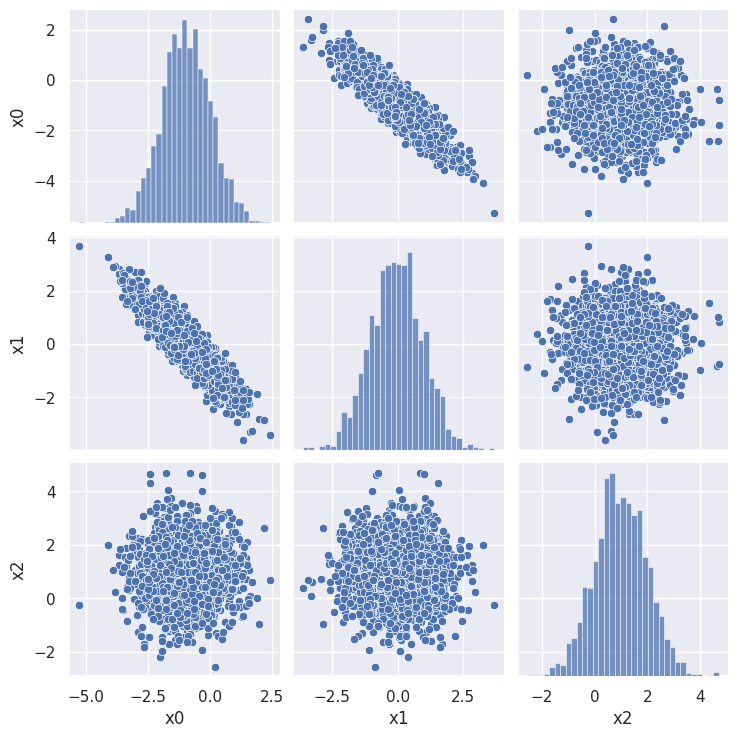

In [41]:
visualize_3d()

Read about [correlation and covariance](https://en.wikipedia.org/wiki/Covariance_and_correlation), then implement the function below to create a 2x2 covariance matrix given values of $\sigma_x$, $\sigma_y$ and the correlation coefficient $\rho$:

In [42]:
def create_2d_covariance(sigma_x, sigma_y, rho):
    """Create and return the 2x2 covariance matrix specified by the input args.
    """
    assert (sigma_x > 0) and (sigma_y > 0), 'sigmas must be > 0.'
    # YOUR CODE HERE
    sx2 = sigma_x ** 2
    sy2 = sigma_y ** 2
    cxy = rho * sigma_x * sigma_y
    mat = np.array([[sx2, cxy],
                    [cxy, sy2]])
    return mat


    #raise NotImplementedError()

In [43]:
# A correct solution should pass these tests.
assert np.array_equal(create_2d_covariance(1., 1.,  0.0), [[1.,  0.], [ 0., 1.]])
assert np.array_equal(create_2d_covariance(2., 1.,  0.0), [[4.,  0.], [ 0., 1.]])
assert np.array_equal(create_2d_covariance(2., 1.,  0.5), [[4.,  1.], [ 1., 1.]])
assert np.array_equal(create_2d_covariance(2., 1., -0.5), [[4., -1.], [-1., 1.]])

Run the following cell that uses your `create_2d_covariance` and `generate_normal` functions to compare the 2D normal distributions with $\rho = 0$ (blue), $\rho = +0.9$ (red) and $\rho = -0.9$ (green):

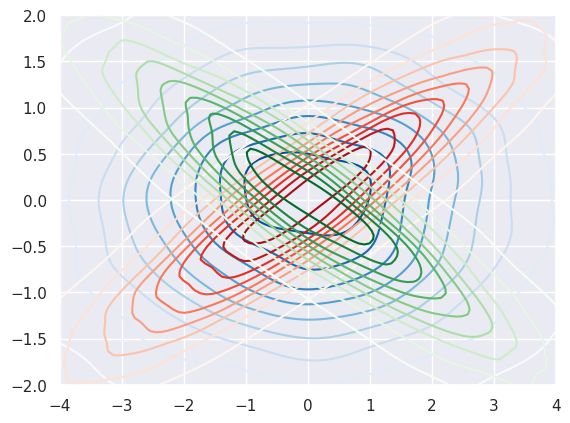

In [44]:
def compare_rhos():
    mu = np.zeros(2)
    sigma_x, sigma_y = 2., 1.
    for rho, cmap in zip((0., +0.9, -0.9), ('Blues', 'Reds', 'Greens')):
        C = create_2d_covariance(sigma_x, sigma_y, rho)
        X = generate_normal(mu, C, 10000)
        sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap=cmap)
    plt.xlim(-4, +4)
    plt.ylim(-2, +2)

compare_rhos()

## <span style="color:Orange">Problem 3</span>

The [Expectation-Maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) is used to implement many machine learning methods, including several we have already studied like K-means and soon to be studied (e.g. factor analysis and weighted PCA.)

The basic idea of EM is to optimize a goal function that depends on two disjoint sets of parameters by alternately updating one set and then the other, using a scheme that is guaranteed to improve the goal function (although generally to a local rather than global optimum). The alternating updates are called the E-step and M-step.

The K-means is one of the simplest uses of EM, so is a good way to get some hands-on experience.

Implement the function below to perform a K-means E-step. Hint: you might find [np.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) and [np.argmin](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) useful.

In [45]:
def E_step(X, centers):
    """Perform a K-means E-step.

    Assign each sample to the cluster with the nearest center, using the
    Euclidean norm to measure distance between a sample and a cluster center.

    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    centers : array with shape (n, D)
        Centers of the the n clusters in D dimensions.

    Returns
    -------
    integer array with shape (N,)
        Cluster index of each sample, in the range 0 to n-1.
    """
    N, D = X.shape
    n = len(centers)
    assert centers.shape[1] == D
    indices = np.empty(N, int)
    # YOUR CODE HERE

    for i in range(N):
        d = np.linalg.norm(centers - X[i], axis=1)
        indices[i] = np.argmin(d)
    #raise NotImplementedError()

    return indices

In [46]:
# A correct solution should pass these tests.
gen = np.random.RandomState(seed=123)
X = gen.normal(size=(100, 2))
centers = np.array([[0., 0.], [0., 10.]])
X[50:] += centers[1]
indices = E_step(X, centers)
assert np.all(indices[:50] == 0)
assert np.all(indices[50:] == 1)

gen = np.random.RandomState(seed=123)
X = gen.normal(size=(20, 2))
centers = gen.uniform(size=(5, 2))
indices = E_step(X, centers)
assert np.array_equal(indices, [4, 1, 4, 4, 1, 0, 1, 0, 2, 1, 2, 4, 0, 1, 0, 1, 0, 1, 4, 4])

Next, implement the function below to perform a K-means M-step:

In [49]:
def M_step(X, indices, n):
    """Perform a K-means M-step.

    Calculate the center of each cluster as the geometric mean of its assigned samples.

    The centers of any clusters without any assigned samples should be set to the origin.

    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    indices : integer array with shape (N,)
        Cluster index of each sample, in the range 0 to n-1.
    n : int
        Number of clusters.  Must be <= N.

    Returns
    -------
    array with shape (n, D)
        Centers of the the n clusters in D dimensions.
    """
    N, D = X.shape
    assert indices.shape == (N,)
    assert n <= N
    centers = np.zeros((n, D))
    # YOUR CODE HERE
    for k in range(n):
        mask = (indices == k)
        if np.any(mask):
            centers[k] = X[mask].mean(axis=0)

    #raise NotImplementedError()

    return centers

In [50]:
# A correct solution should pass these tests.
gen = np.random.RandomState(seed=123)
X = np.ones((20, 2))
indices = np.zeros(20, int)
centers = M_step(X, indices, 1)
assert np.all(centers == 1.)

n = 5
indices = gen.randint(n, size=len(X))
centers = M_step(X, indices, n)
assert np.all(centers == 1.)

X = gen.uniform(size=X.shape)
centers = M_step(X, indices, n)
assert np.allclose(
    np.round(centers, 3),
    [[ 0.494,  0.381], [ 0.592,  0.645],
     [ 0.571,  0.371], [ 0.234,  0.634],
     [ 0.250,  0.386]])

You have now implemented the core of the K-means algorithm.  Try it out with this simple wrapper, which makes a scatter plot of the first two columns after each iteration. The sklearn wrapper combines the result of several random starting points and has other refinements.

In [51]:
def KMeans_fit(data, n_clusters, nsteps, seed=123):
    X = data.values
    N, D = X.shape
    assert n_clusters <= N
    gen = np.random.RandomState(seed=seed)
    # Pick random samples as the initial centers.
    shuffle = gen.permutation(N)
    centers = X[shuffle[:n_clusters]]
    # Perform an initial E step to assign samples to clusters.
    indices = E_step(X, centers)
    # Loop over iterations.
    for i in range(nsteps):
        centers = M_step(X, indices, n_clusters)
        indices = E_step(X, centers)
    # Plot the result.
    cmap = np.array(sns.color_palette())
    plt.scatter(X[:, 0], X[:, 1], c=cmap[indices % len(cmap)])
    plt.scatter(centers[:, 0], centers[:, 1], marker='+', c='k', s=400, lw=5)
    plt.show()

Try it out on some randomly generated 2D data with 3 separate clusters (using the handy [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)):

In [52]:
from sklearn.datasets import make_blobs
gen = np.random.RandomState(seed=123)
X, _ = make_blobs(n_samples=500, n_features=2, centers=[[-3,-3],[0,3],[3,-3]], random_state=gen)
data = pd.DataFrame(X, columns=('x0', 'x1'))

For this simple test, you should find a good solution after two iterations:

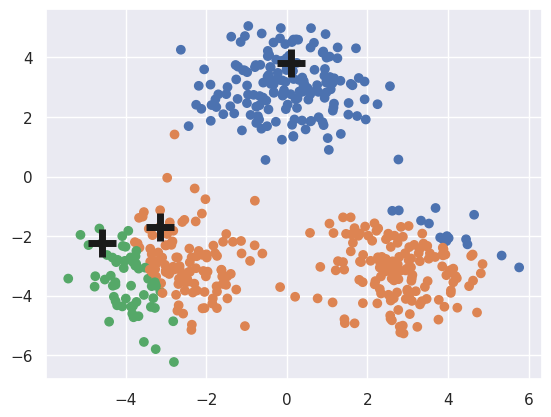

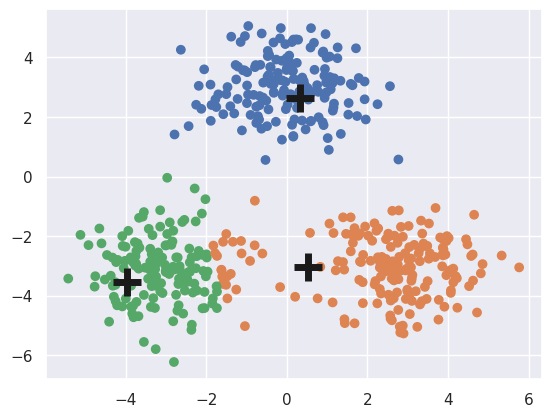

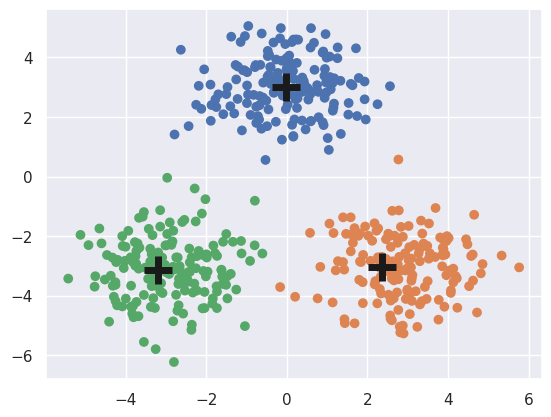

In [53]:
KMeans_fit(data, n_clusters=3, nsteps=0);
KMeans_fit(data, n_clusters=3, nsteps=1);
KMeans_fit(data, n_clusters=3, nsteps=2);

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2025